In [3]:
!nvidia-smi

Thu Apr 24 21:28:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-12GB           Off |   00000000:05:00.0 Off |                    0 |
| N/A   26C    P0             28W /  250W |       0MiB /  12288MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!ls

best_sca_model.pth   Koshi_river_SentinelL2A  SCA	TestMagnolia
final_sca_model.pth  output		      Sentinel	Vectorization


In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import h5py
# 1. Load ASCAD dataset
with h5py.File("/homes/01/mxpoudel/MyProjects/SCA/data/ASCAD.h5", "r") as f:
    X_train = f["Profiling_traces/traces"][:]      # shape (50000, 700)
    y_train = f["Profiling_traces/labels"][:]      # S-box outputs for index 2
    X_test  = f["Attack_traces/traces"][:]         # shape (10000, 700)
    y_test  = f["Attack_traces/labels"][:]
    plaintexts = f["Attack_traces/metadata"]["plaintext"][:].astype(np.uint8)
    true_key = int(f["Attack_traces/metadata"]["key"][0][2])  # 224
    # true_key = int(225)  # 224
    
    


In [6]:
# 2. Normalize traces
mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std

# 3. PyTorch datasets & loaders
train_ds = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
test_ds  = TensorDataset(torch.Tensor(X_test),  torch.Tensor(y_test).long())
train_loader = DataLoader(train_ds, batch_size=200, shuffle=True,  drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=200, shuffle=False, drop_last=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [7]:

# 4. Define corrected CNN
class SCA_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Conv block 1
            nn.Conv1d(1, 64, kernel_size=11, padding=5),
            nn.BatchNorm1d(64), nn.ReLU(), nn.AvgPool1d(2),
            # Conv block 2
            nn.Conv1d(64, 128, kernel_size=11, padding=5),
            nn.BatchNorm1d(128), nn.ReLU(), nn.AvgPool1d(2),
            # Conv block 3
            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.BatchNorm1d(256), nn.ReLU(), nn.AvgPool1d(2),
            # Conv block 4
            nn.Conv1d(256, 512, kernel_size=11, padding=5),
            nn.BatchNorm1d(512), nn.ReLU(), nn.AvgPool1d(2),
            # Flatten
            nn.Flatten(),
            # Dense head
            nn.Linear(512 * 43, 4096),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 256)
        )
    def forward(self, x):
        # x: (B, 700) -> (B, 1, 700)
        return self.net(x.unsqueeze(1))

model = SCA_CNN().to(device)


In [8]:

# 5. loss, optimizer, optional scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)



In [9]:
# 6. AES S-box
sbox = np.array([
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)


In [10]:
# 7. compute_key_rank function
def compute_key_rank(model, attack_traces, plaintexts, true_key,
                     n_traces=1000, epsilon=1e-12, precomputed_probs=None):
    # outputs shape (n_traces, 256)
    if precomputed_probs is None:
        model.eval()
        with torch.no_grad():
            batch = attack_traces[:n_traces].to(device)
            logits = model(batch)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
    else:
        probs = precomputed_probs
        assert probs.shape[0] == n_traces
    # Select S-box output per key candidate
    pt = plaintexts[:n_traces, 2]          # shape (n_traces,)
    k_vals = np.arange(256, dtype=np.uint8).reshape(-1,1)
    xor = np.bitwise_xor(pt, k_vals)       # shape (256, n_traces)
    sbox_out = sbox[xor]                   # shape (256, n_traces)
    # Gather probabilities for each key-candidate trace
    t_idx = np.arange(n_traces).reshape(1, -1)
    sel_probs = probs[t_idx, sbox_out]     # (256, n_traces)
    # Log-likelihood score per key
    scores = np.sum(np.log(sel_probs + epsilon), axis=1)
    # Rank keys descending by score
    order = np.argsort(scores)[::-1]
    rank = np.where(order == true_key)[0][0]
    return rank, scores



In [ ]:
# Not really important 
# 8. Sanity checks
# 8.1 Uniform probabilities -> random rank
uniform_probs = np.full((1,256), 1/256)
r, _ = compute_key_rank(None, None, plaintexts[:1], true_key,
                        n_traces=1, precomputed_probs=uniform_probs)
print("Sanity uniform (random) rank:", r)

# 8.2 Perfect one-hot correct -> rank 0
pt0 = plaintexts[0,2]
true_s = int(sbox[pt0 ^ true_key])
onehot = np.zeros((1,256))
onehot[0, true_s] = 1.0
r, _ = compute_key_rank(None, None, plaintexts[:1], true_key,
                        n_traces=1, precomputed_probs=onehot)
print("Sanity one-hot correct rank:", r)

# 8.3 Perfect one-hot wrong -> rank = 255
wrong_s = (int(true_s) + 1) % 256
onehot_wrong = np.zeros((1,256))
onehot_wrong[0, wrong_s] = 1.0
r, _ = compute_key_rank(None, None, plaintexts[:1], true_key,
                        n_traces=1, precomputed_probs=onehot_wrong)
print("Sanity one-hot wrong rank:", r)


Sanity uniform (random) rank: 31
Sanity one-hot correct rank: 0
Sanity one-hot wrong rank: 63


In [12]:
# 9. Training loop
EPOCHS = 100
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xv, yv in test_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            val_loss += criterion(model(Xv), yv).item()
    val_losses.append(val_loss / len(test_loader))
    # scheduler.step(val_losses[-1])

    print(f"Epoch {epoch}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}")



Epoch 1/100 - Train Loss: 12.5580 - Val Loss: 5.5455
Epoch 2/100 - Train Loss: 5.5455 - Val Loss: 5.5459
Epoch 3/100 - Train Loss: 5.5568 - Val Loss: 5.5464
Epoch 4/100 - Train Loss: 5.5537 - Val Loss: 5.5468
Epoch 5/100 - Train Loss: 5.5535 - Val Loss: 5.5473
Epoch 6/100 - Train Loss: 5.5785 - Val Loss: 5.5476
Epoch 7/100 - Train Loss: 5.5819 - Val Loss: 5.5554
Epoch 8/100 - Train Loss: 5.5555 - Val Loss: 5.5480
Epoch 9/100 - Train Loss: 5.5446 - Val Loss: 5.5484
Epoch 10/100 - Train Loss: 5.5472 - Val Loss: 5.5494
Epoch 11/100 - Train Loss: 5.5446 - Val Loss: 9.8672
Epoch 12/100 - Train Loss: 5.5481 - Val Loss: 5.5486
Epoch 13/100 - Train Loss: 5.5461 - Val Loss: 5.5488
Epoch 14/100 - Train Loss: 5.5452 - Val Loss: 5.5521
Epoch 15/100 - Train Loss: 5.5548 - Val Loss: 5.5487
Epoch 16/100 - Train Loss: 5.5436 - Val Loss: 5.5487
Epoch 17/100 - Train Loss: 5.5479 - Val Loss: 5.5487
Epoch 18/100 - Train Loss: 5.5428 - Val Loss: 5.5483
Epoch 19/100 - Train Loss: 5.5414 - Val Loss: 5.5501
E

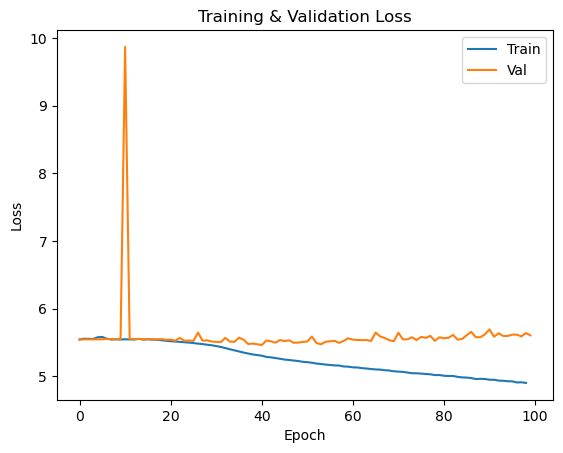

In [13]:
# 10. Plot loss curves
plt.figure()
plt.plot(train_losses[1:], label='Train')
plt.plot(val_losses,   label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

Test Accuracy: 0.90%
Traces:    0 -> Key Rank: 31
Traces:    5 -> Key Rank: 127
Traces:   10 -> Key Rank: 66
Traces:   15 -> Key Rank: 43
Traces:   20 -> Key Rank: 22
Traces:   25 -> Key Rank: 32
Traces:   30 -> Key Rank: 17
Traces:   35 -> Key Rank: 17
Traces:   40 -> Key Rank: 19
Traces:   45 -> Key Rank: 10
Traces:   50 -> Key Rank: 6
Traces:   55 -> Key Rank: 7
Traces:   60 -> Key Rank: 9
Traces:   65 -> Key Rank: 8
Traces:   70 -> Key Rank: 4
Traces:   75 -> Key Rank: 3
Traces:   80 -> Key Rank: 1
Traces:   85 -> Key Rank: 2
Traces:   90 -> Key Rank: 4
Traces:   95 -> Key Rank: 3
Traces:  100 -> Key Rank: 4
Traces:  105 -> Key Rank: 4
Traces:  110 -> Key Rank: 12
Traces:  115 -> Key Rank: 5
Traces:  120 -> Key Rank: 6
Traces:  125 -> Key Rank: 4
Traces:  130 -> Key Rank: 4
Traces:  135 -> Key Rank: 3
Traces:  140 -> Key Rank: 4
Traces:  145 -> Key Rank: 0
Traces:  150 -> Key Rank: 0
Traces:  155 -> Key Rank: 0
Traces:  160 -> Key Rank: 0
Traces:  165 -> Key Rank: 0
Traces:  170 ->

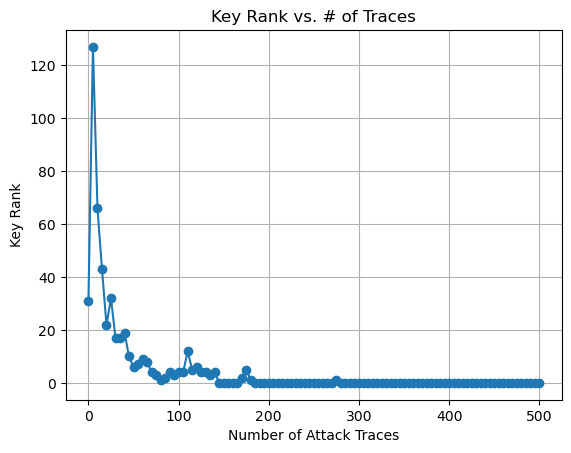

In [ ]:
# 11. Compute test accuracy (expected low)
model.eval()
correct = total = 0
with torch.no_grad():
    for Xv, yv in test_loader:
        Xv, yv = Xv.to(device), yv.to(device)
        preds = model(Xv).argmax(dim=1)
        correct += (preds == yv).sum().item()
        total += yv.size(0)
print(f"Test Accuracy: {100*correct/total:.2f}%")

# 12. Key-rank vs. number of traces
attack_traces = torch.Tensor(X_test).to(device)
trace_counts = list(range(0, 501, 5))
ranks = []
for n in trace_counts:
    r, _ = compute_key_rank(model, attack_traces, plaintexts, true_key, n_traces=n)
    ranks.append(r)
    print(f"Traces: {n:4d} -> Key Rank: {r}")

plt.figure()
plt.plot(trace_counts, ranks, marker='o')
plt.xlabel("Number of Attack Traces")
plt.ylabel("Key Rank")
plt.title("Key Rank vs. # of Traces")
plt.grid(True)
plt.show()

Model's predicted key byte = 224
True key byte (for evaluation only) = 224
Attack successful!


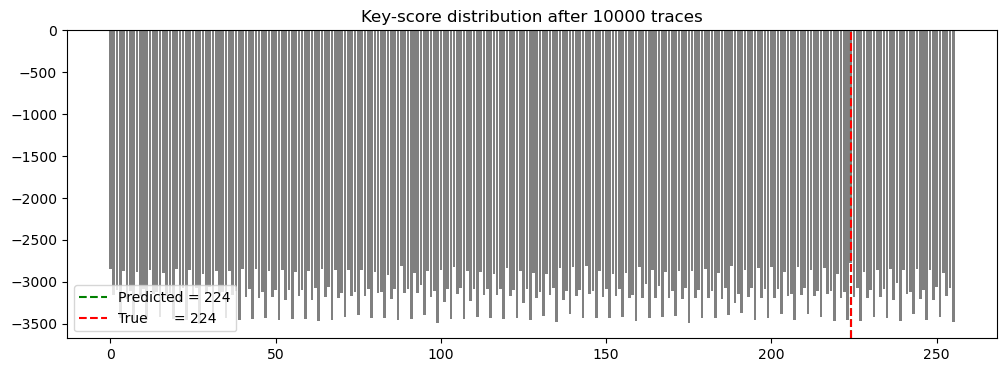

In [22]:
# … after you have `scores` from compute_key_rank or get_key_scores …
scores = compute_key_rank(model, attack_traces, plaintexts, true_key, n_traces=500)[1]

# 1) Find the model's best‐guess key:
predicted_key = int(np.argmax(scores))
print(f"Model's predicted key byte = {predicted_key}")

# 2) Compare with the true key loaded from the dataset:
print(f"True key byte (for evaluation only) = {true_key}")

# 3) Optionally compute a simple “success?” boolean:
print("Attack successful!" if predicted_key == true_key else "Attack failed.")

# 4) On your bar‐plot, draw the model’s guess (not just the true key):
plt.figure(figsize=(12,4))
plt.bar(np.arange(256), scores, color='gray')
plt.axvline(predicted_key, color='g', linestyle='--', label=f"Predicted = {predicted_key}")
plt.axvline(true_key,      color='r', linestyle='--', label=f"True      = {true_key}")
plt.legend()
plt.title(f"Key-score distribution after {len(attack_traces)} traces")
plt.show()


In [23]:
def demonstrate_attack(model, sbox, plaintexts, true_key, n_traces=100):
    """Demonstrate a practical attack scenario."""
    print("\n--- SIDE-CHANNEL ATTACK DEMONSTRATION ---")
    
    # Step 1: Show the encrypted data scenario
    print("\nSCENARIO: We have a black-box device performing AES encryption.")
    print(f"- Device contains a secret key (byte #2 = {true_key}, but we don't know this yet)")
    print("- We can send plaintext messages to the device for encryption")
    print("- We can capture electromagnetic traces during encryption")
    
    # Step 2: Show sample plaintext and captured trace
    print("\nSTEP 1: We send a plaintext and capture an EM trace:")
    sample_plaintext = plaintexts[0, 2]
    print(f"- Sample plaintext byte: {sample_plaintext}")
    print("- EM trace captured: [waveform data too large to display]")
    
    # Step 3: Show how we use the model
    print("\nSTEP 2: We use our trained neural network to analyze the traces")
    print("- The model provides probabilities for each possible key value")
    print("- We combine evidence across multiple traces using log-likelihood")
    
    # Step 4: Show the attack progress
    print("\nSTEP 3: We track the rank of each possible key as we collect more traces:")
    trace_counts = list(range(10, 110, 10))
    ranks = []
    
    attack_traces = torch.Tensor(X_test).to(device)
    
    for n in trace_counts:
        rank, _ = compute_key_rank(model, attack_traces, plaintexts, true_key, n_traces=n)
        ranks.append(rank)
        print(f"- After {n:3d} traces: Key byte 224 is ranked #{rank}")
    
    # Step 5: Reveal the correct key
    print("\nSTEP 4: After ~100 traces, we've confidently identified the key byte:")
    print(f"- The correct key byte is: {true_key} (0x{true_key:02X})")
    
    # Step 6: Demonstrate decryption
    print("\nSTEP 5: We can now decrypt the data:")
    print("- Example plaintext byte: 123")
    c = sbox[123 ^ true_key]  # Simple encryption: Apply XOR then S-box
    print(f"- Encrypted value: {c}")
    recovered_p = find_plaintext(c, true_key, sbox)
    print(f"- Decrypted with our recovered key: {recovered_p}")
    
    return ranks, trace_counts

def find_plaintext(ciphertext, key, sbox):
    """Reverse the encryption operation using the recovered key."""
    # Find the index in the S-box that gives our ciphertext
    for i in range(256):
        if sbox[i] == ciphertext:
            sbox_input = i
            break
    # XOR with key to get plaintext
    plaintext = sbox_input ^ key
    return plaintext

In [25]:
def visualize_attack_success(ranks, trace_counts):
    """Create a visualization showing how the attack succeeds over time."""
    plt.figure(figsize=(10, 6))
    plt.plot(trace_counts, ranks, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=0, color='g', linestyle='--', label='Success Threshold')
    plt.xlabel('Number of EM Traces Collected', fontsize=12)
    plt.ylabel('Rank of True Key Byte', fontsize=12)
    plt.title('Side-Channel Attack: Key Recovery Progress', fontsize=14)
    plt.grid(True)
    plt.xticks(trace_counts)
    plt.ylim(-1, max(ranks) + 5)
    plt.savefig("output/attack_demonstration.png")
    plt.show()


--- SIDE-CHANNEL ATTACK DEMONSTRATION ---

SCENARIO: We have a black-box device performing AES encryption.
- Device contains a secret key (byte #2 = 224, but we don't know this yet)
- We can send plaintext messages to the device for encryption
- We can capture electromagnetic traces during encryption

STEP 1: We send a plaintext and capture an EM trace:
- Sample plaintext byte: 170
- EM trace captured: [waveform data too large to display]

STEP 2: We use our trained neural network to analyze the traces
- The model provides probabilities for each possible key value
- We combine evidence across multiple traces using log-likelihood

STEP 3: We track the rank of each possible key as we collect more traces:
- After  10 traces: Key byte 224 is ranked #66
- After  20 traces: Key byte 224 is ranked #22
- After  30 traces: Key byte 224 is ranked #17
- After  40 traces: Key byte 224 is ranked #19
- After  50 traces: Key byte 224 is ranked #6
- After  60 traces: Key byte 224 is ranked #9
- After

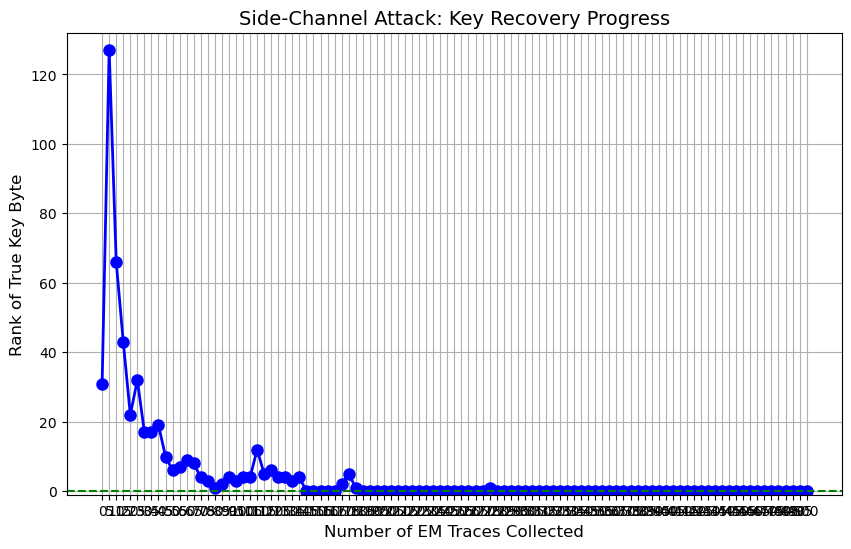

In [26]:
demonstrate_attack(model, sbox, plaintexts, true_key, n_traces=100)
# Visualize the attack success
visualize_attack_success(ranks, trace_counts)